# Setup

In [1]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties
import seaborn as sns
import numpy as np
from datetime import datetime
from datasets import load_dataset

## Load metadata

In [2]:
models_data_file = '../data/models/models_data.tsv'
large_scale_file = '../data/models/epoch_large_scale_ai_models.csv'
notable_file = '../data/models/epoch_notable_ai_models.csv'

# Load and combine Epoch AI model metadata
# [1] https://epochai.org/data/large-scale-ai-models  
# [2] https://epochai.org/data/notable-ai-models
notable_df = pd.read_csv(notable_file)
large_scale_df = pd.read_csv(large_scale_file)

epoch_df = pd.concat([notable_df, large_scale_df], ignore_index=True)
epoch_df = epoch_df.drop_duplicates(subset='System', keep='first')

# Load Lenni-collected metadata and combine with Epoch AI metadata
models_df = pd.read_csv(models_data_file, sep='\t')
models_metadata = models_df.merge(epoch_df, left_on='epoch_model_name', right_on='System', how='left')

## Utility functions for calculating cost

In [3]:
def clean_cost(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        return float(value.replace('$', '').replace(',', ''))
    return float(value)

def calculate_cost(input_tokens, output_tokens, model_name, models_df):
    model_data = models_df[models_df['inspect_model_name'] == model_name].iloc[0]
    input_cost_per_M = clean_cost(model_data['input_cost_per_M_tokens'])
    output_cost_per_M = clean_cost(model_data['output_cost_per_M_tokens'])
    cost_per_M = clean_cost(model_data['cost_per_M_tokens'])
    
    if input_cost_per_M and output_cost_per_M:
        input_cost = (input_cost_per_M / 1_000_000) * input_tokens
        output_cost = (output_cost_per_M / 1_000_000) * output_tokens
        total_cost = input_cost + output_cost
    elif cost_per_M:
        total_cost = (cost_per_M / 1_000_000) * (input_tokens + output_tokens)
    else:
        total_cost = 0
    
    return round(total_cost, 2)

## Loading inspect logs

In [4]:
zshot_1run_path = '../data/results/zero-shot-1run/{}/logs'
zshot_10run_path = '../data/results/zero-shot-10run/{}/logs/{}'
zshot_cot_10run_path = '../data/results/zero-shot-cot-10run/{}/logs/{}'

# For 10-run results
model_dir_names = [
    'gpt-4o',
    'gemini-1.5-pro',
    'claude-3.5-sonnet',
    'llama-3.1-405b'
]

In [5]:
def process_log_file_dir(log_file_dir):
    """Load directory of Inspect log files into a dataframe"""
    results = []

    for filename in os.listdir(log_file_dir):
        if filename.endswith('.json'):
            file_path = os.path.join(log_file_dir, filename)
            with open(file_path, 'r') as f:
                log = json.load(f)
            
            if log['status'] == "success":
                model_name = log['eval']['model']
                
                # Extract data from logs
                accuracy = next((score['metrics']['accuracy']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                stderr = next((score['metrics']['stderr']['value'] for score in log['results']['scores'] if score['name'] == 'choice'), None)
                token_usage = sum(usage['total_tokens'] for usage in log['stats']['model_usage'].values())
                task_name = log['eval']['task']
                dataset_samples = log['eval']['dataset']['samples']
                completed_samples = log['results']['completed_samples']
                input_tokens = sum(usage['input_tokens'] for usage in log['stats']['model_usage'].values())
                output_tokens = sum(usage['output_tokens'] for usage in log['stats']['model_usage'].values())
                start_time = log['stats']['started_at']
                end_time = log['stats']['completed_at']
                
                run_cost = calculate_cost(input_tokens, output_tokens, model_name, models_df)
                
                results.append({
                    'inspect_model_name': model_name,
                    'accuracy': accuracy,
                    'stderr': stderr,
                    'total_tokens': token_usage,
                    'input_tokens': input_tokens,
                    'output_tokens': output_tokens,
                    'task': task_name,
                    'dataset_samples': dataset_samples,
                    'completed_samples': completed_samples,
                    'run_id': log['eval']['run_id'],
                    'created': log['eval']['created'],
                    'start_time': start_time,
                    'end_time': end_time,
                    'filename': filename,
                    'estimated_cost': run_cost
                })
    
    return pd.DataFrame(results)

## Computing random guess accuracy with varying number of options per question

In [6]:
def compute_random_baseline(dataset, name, split):
    dataset = load_dataset(dataset, name=name, split=split)
    
    # Calculate the number of options for each question
    num_options = [len(record['distractors']) + 1 for record in dataset]  # +1 for the correct answer
    
    # Calculate the probability of guessing correctly for each question
    probabilities = [1/n for n in num_options]
    
    # Compute the average probability
    random_guess_baseline = np.mean(probabilities)
    
    return random_guess_baseline

## Plotting functions

In [7]:
def plot_performance_over_time(ax, zshot_1run_df, manual_offsets, baselines, color_map, ylim, legend_loc='best'):
    # Function to parse dates
    def parse_date(date_str):
        try:
            return datetime.strptime(date_str, "%Y-%m-%d")
        except:
            return None

    # Prepare the data
    plot_data = zshot_1run_df.copy()
    plot_data['Publication date'] = plot_data['Publication date'].apply(parse_date)
    plot_data['accuracy'] = plot_data['accuracy'].astype(float)
    plot_data['stderr'] = plot_data['stderr'].astype(float)

    # Filter for models with biggest_in_class = 1
    largest_models = plot_data[plot_data['biggest_in_class'] == 1].sort_values('Publication date')

    # Plot the data
    for org in color_map.keys():
        org_data = largest_models[largest_models['Organization'] == org]
        ax.scatter(org_data['Publication date'], org_data['accuracy'], 
                   label=org, color=color_map[org], s=80, alpha=0.7)
        ax.plot(org_data['Publication date'], org_data['accuracy'], linewidth=3.5,
                color=color_map[org], alpha=0.5)
        
        for _, row in org_data.iterrows():
            offset = manual_offsets.get(row['epoch_model_name'], (5, 5))
            ax.annotate(row['epoch_model_name'], 
                        (row['Publication date'], row['accuracy']),
                        xytext=offset, textcoords='offset points',
                        fontsize=10, alpha=0.8, rotation=0, ha='left', va='bottom')

    # Add baseline reference lines
    for baseline, properties in baselines.items():
        ax.axhline(y=properties['value'], color=properties['color'], 
                   linestyle=properties['linestyle'], alpha=0.7, linewidth=2.0, 
                   label=properties['label'])

    # Customize the subplot
    ax.set_xlabel("Model publication date", fontsize=14)
    ax.set_ylabel("Accuracy (0-shot, 1 run)", fontsize=14)
    ax.set_ylim(ylim)

    # Format x-axis
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    # Add grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust tick parameters
    tick_color = mcolors.to_rgba(plt.rcParams['grid.color'], alpha=0.7)
    ax.tick_params(axis='x', which='major', length=6, color=tick_color, direction='out')
    ax.tick_params(axis='x', which='minor', length=3, color=tick_color, direction='out')

    # Remove labels for minor ticks (months)
    ax.xaxis.set_tick_params(which='minor', bottom=True, top=False, labelbottom=False)
    ax.xaxis.set_tick_params(which='major', bottom=True, top=False, labelbottom=True)

    # Create a single legend with two sections
    handles, labels = ax.get_legend_handles_labels()
    
    # Split handles and labels into organizations and baselines
    org_handles = handles[:len(color_map)]
    org_labels = labels[:len(color_map)]
    baseline_handles = handles[len(color_map):]
    baseline_labels = labels[len(color_map):]

    # Remove 'nan' from org_labels and corresponding handle
    org_labels = [label for label in org_labels if label != 'nan']
    org_handles = [handle for handle, label in zip(org_handles, labels[:len(color_map)]) if label != 'nan']

    # Create a legend with two sections
    spacer = plt.Line2D([0], [0], color='none', marker='', linestyle='', label='_')
    legend_elements = [
        plt.Line2D([0], [0], color='w', alpha=0, label='Organization'),
        *[plt.Line2D([0], [0], color=color_map[org], lw=4, alpha=0.7, label=org) for org in org_labels],
       spacer,
        plt.Line2D([0], [0], color='w', alpha=0, label='Baselines'),
        *[plt.Line2D([0], [0], color=baselines[label]['color'], 
                     linestyle=baselines[label]['linestyle'], lw=2, label=label, alpha=0.7) 
          for label in baseline_labels]
    ]

    # Add the combined legend
    legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)
    legend.get_frame().set_alpha(1)

    # Set the bold font for section titles in the legend
    for text in legend.get_texts():
        if text.get_text() in ['Organization', 'Baselines']:
            text.set_fontweight('bold')
            text.set_fontsize(12)

    # Adjust the plot layout to make room for the legend
    plt.tight_layout()

In [8]:
def plot_accuracy_boxplot(ax, zshot_10run_df, baselines, xlim, zshot_cot_10run_df=None):
    no_cot_color = '#5ab4ac'  # Blue for No CoT
    cot_color = '#d8b365'     # Orange for CoT

    no_cot_dot_color = '#387b75'
    cot_dot_color = '#8e6c24'

    # Prepare the data
    zshot_10run_df['cot'] = 'No CoT'
    if zshot_cot_10run_df is not None:
        zshot_cot_10run_df['cot'] = 'CoT'
        combined_df = pd.concat([zshot_10run_df, zshot_cot_10run_df])
        has_cot = True
    else:
        combined_df = zshot_10run_df
        has_cot = False

    # Sort models by median accuracy (combining both CoT and No CoT)
    model_order = combined_df.groupby('epoch_model_name')['accuracy'].median().sort_values(ascending=False).index

    # Create box plot with slight separation between CoT and No CoT
    sns.boxplot(x='accuracy', y='epoch_model_name', hue='cot', data=combined_df, 
                ax=ax, palette={'No CoT': no_cot_color, 'CoT': cot_color}, width=0.6, 
                showfliers=False, order=model_order, dodge=has_cot)

    # Customize the subplot
    ax.set_xlabel('Accuracy (0-shot, 10 runs)', fontsize=14)
    ax.set_ylabel('')
    ax.set_xlim(xlim)

    # Add grid lines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add baseline reference lines
    for baseline, properties in baselines.items():
        ax.axvline(x=properties['value'], color=properties['color'], 
                   linestyle=properties['linestyle'], alpha=0.7, 
                   label=properties['label'])

    # Add jittered points with matching colors
    conditions = ['No CoT', 'CoT'] if has_cot else ['No CoT']
    for i, cot in enumerate(conditions):
        data = combined_df[combined_df['cot'] == cot]
        color = no_cot_dot_color if cot == 'No CoT' else cot_dot_color
        
        # Calculate the y-position offset
        if has_cot:
            y_offset = -0.17 if cot == 'No CoT' else 0.17
        else:
            y_offset = 0  # Center the points when there's only No CoT data
        
        # Add jittered points
        for j, model in enumerate(model_order):
            model_data = data[data['epoch_model_name'] == model]
            y_positions = np.random.normal(j + y_offset, 0.05, len(model_data))
            ax.scatter(model_data['accuracy'], y_positions, color=color, alpha=0.7, s=15, zorder=10)

    # Rotate y-axis labels
    plt.setp(ax.get_yticklabels(), rotation=45, ha='right', va='center')

    # Customize legend
    if has_cot:
        handles, labels = ax.get_legend_handles_labels()
        # Keep only the first two handles (boxplot colors) and remove the point colors
        legend = ax.legend(handles[:2], labels[:2], title='Condition', fontsize=10, loc='lower right')
        legend.get_frame().set_alpha(1)

        # Customize legend text
        plt.setp(legend.get_title(), fontsize=12, fontweight='bold')  # Set title font size and make it bold
        plt.setp(legend.get_texts(), fontsize=12)  # Set label font size
    else:
        ax.get_legend().remove()  # Remove the legend if there's no CoT data

In [9]:
def create_benchmark_figure(zshot_1run_df, zshot_10run_df, manual_offsets, baselines, benchmark_name, ylim, xlim, zshot_cot_10run_df=None, legend_loc='best'):
    # Set up the plot style
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 12
    sns.set_style("whitegrid")

    # Create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), dpi=300, gridspec_kw={'width_ratios': [1.5, 1]})

    # Create a color map for organizations
    zshot_1run_df['Organization'] = zshot_1run_df['Organization'].astype(str)
    zshot_10run_df['Organization'] = zshot_10run_df['Organization'].astype(str)
    if zshot_cot_10run_df is not None:
        zshot_cot_10run_df['Organization'] = zshot_cot_10run_df['Organization'].astype(str)
    organizations = sorted(zshot_1run_df['Organization'].unique())
    color_palette = sns.color_palette("deep", len(organizations))
    color_map = dict(zip(organizations, color_palette))

    # Plot the left subplot: Model performance over time
    plot_performance_over_time(ax1, zshot_1run_df, manual_offsets, baselines, color_map, ylim, legend_loc)

    # Plot the right subplot: Box plot of model accuracies
    plot_accuracy_boxplot(ax2, zshot_10run_df, baselines, xlim, zshot_cot_10run_df)

    # Set overall title
    fig.suptitle(f"Model Performance on {benchmark_name} Benchmark", fontsize=16, fontweight='bold')

    # Adjust layout
    plt.tight_layout()

    # Save the figure
    plt.savefig(f'../figures/{benchmark_name.lower()}.png', dpi=300, bbox_inches='tight')
    plt.show()

## Figure 1 - MMLU

In [10]:
mmlu_zshot_1run_results = process_log_file_dir(zshot_1run_path.format('mmlu'))
mmlu_zshot_1run_df = mmlu_zshot_1run_results.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

mmlu_zshot_10run_results = {}
for model in model_dir_names:
    mmlu_zshot_10run_results[model] = process_log_file_dir(zshot_10run_path.format('mmlu', model))
mmlu_zshot_10run_df = pd.concat(mmlu_zshot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

In [11]:
offsets = {
    "GPT-3.5 Turbo": (-10, 10),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-10, 10),
    "Claude 2": (-10, 10),
    "Claude 3 Opus": (-28, 5),
    "Claude 3.5 Sonnet": (-20, 5),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-40, -20),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-10, 10),
    "Gemini 1.5 Pro": (-40, -20),
    "Mixtral 8x7B": (-10, 10),
    "Mistral Large 2": (-40, -20)
}

baselines = {
    "Expert accuracy": {"value": 0.898, "color": '#092327', "linestyle": '--', "label": 'Expert accuracy'},
    "Non-expert accuracy": {"value": 0.345, "color": '#0b5351', "linestyle": '-.', "label": 'Non-expert accuracy'},
    "Random guess": {"value": 0.25, "color": '#00a9a5', "linestyle": ':', "label": 'Random guess'}
}

ylim = (0.2, 1.0)
xlim = (0.2, 1.0)

/var/folders/d_/hv1jrf512w51cf1t0s2w52v00000gn/T/ipykernel_45907/2621642398.py:92: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)


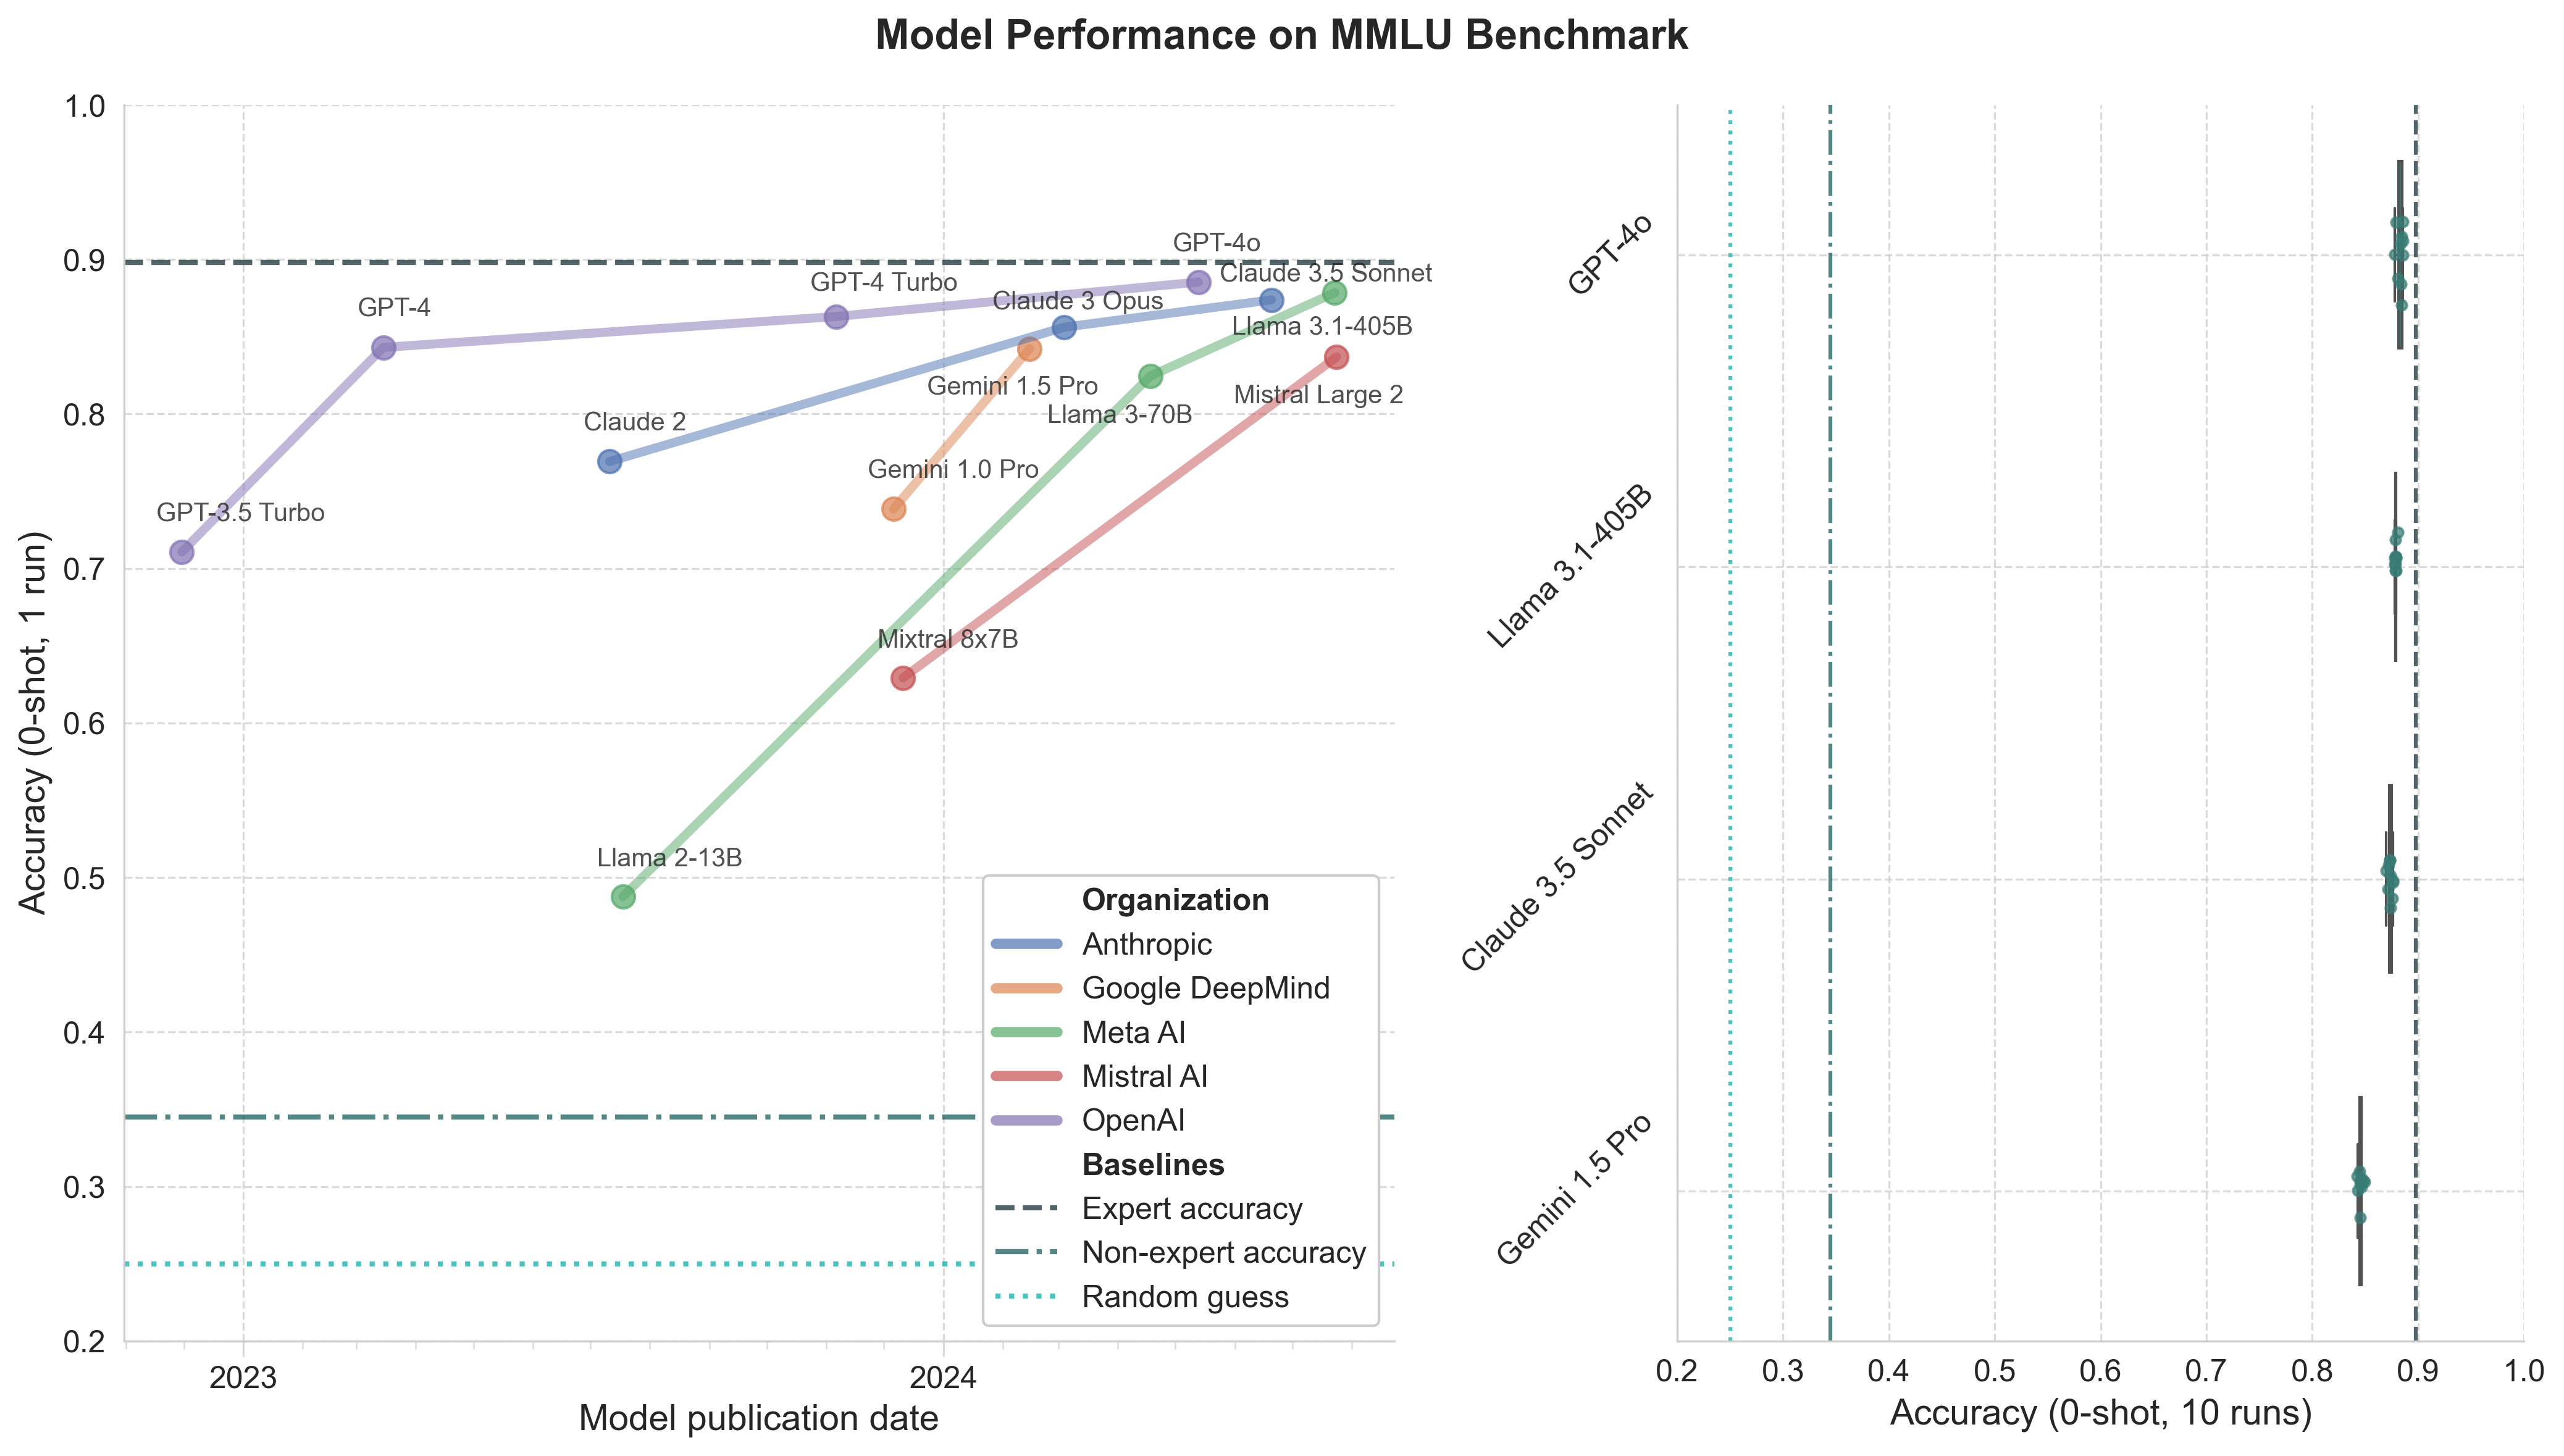

In [12]:
create_benchmark_figure(mmlu_zshot_1run_df, mmlu_zshot_10run_df, offsets, baselines, "MMLU", ylim, xlim, legend_loc='lower right')

## Figure 2 - GPQA

In [13]:
gpqa_zshot_1run_results = process_log_file_dir(zshot_1run_path.format('gpqa'))
gpqa_zshot_1run_df = gpqa_zshot_1run_results.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

gpqa_zshot_10run_results = {}
gpqa_zshot_cot_10run_results = {}
for model in model_dir_names:
    gpqa_zshot_10run_results[model] = process_log_file_dir(zshot_10run_path.format('gpqa', model))
    gpqa_zshot_cot_10run_results[model] = process_log_file_dir(zshot_cot_10run_path.format('gpqa', model))
gpqa_zshot_10run_df = pd.concat(gpqa_zshot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')
gpqa_zshot_cot_10run_df = pd.concat(gpqa_zshot_cot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

In [14]:
offsets = {
    "GPT-3.5 Turbo": (-10, 6),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-10, 10),
    "Claude 2": (-20, 15),
    "Claude 3 Opus": (-50, 10),
    "Claude 3.5 Sonnet": (-20, 5),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-20, -20),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-60, 10),
    "Gemini 1.5 Pro": (-40, -20),
    "Mixtral 8x7B": (-10, 10),
    "Mistral Large 2": (-40, -20)
}

baselines = {"Expert accuracy": {"value": 0.667, "color": '#092327', "linestyle": '--', "label": 'Expert accuracy'},
    
    "Non-expert accuracy": {"value": 0.432, "color": '#0b5351', "linestyle": '-.', "label": 'Non-expert accuracy'},
    "Random guess": {"value": 0.25, "color": '#00a9a5', "linestyle": ':', "label": 'Random guess'}
}

ylim = (0.2, 1.0)
xlim = (0.2, 1.0)

/var/folders/d_/hv1jrf512w51cf1t0s2w52v00000gn/T/ipykernel_45907/2621642398.py:92: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)


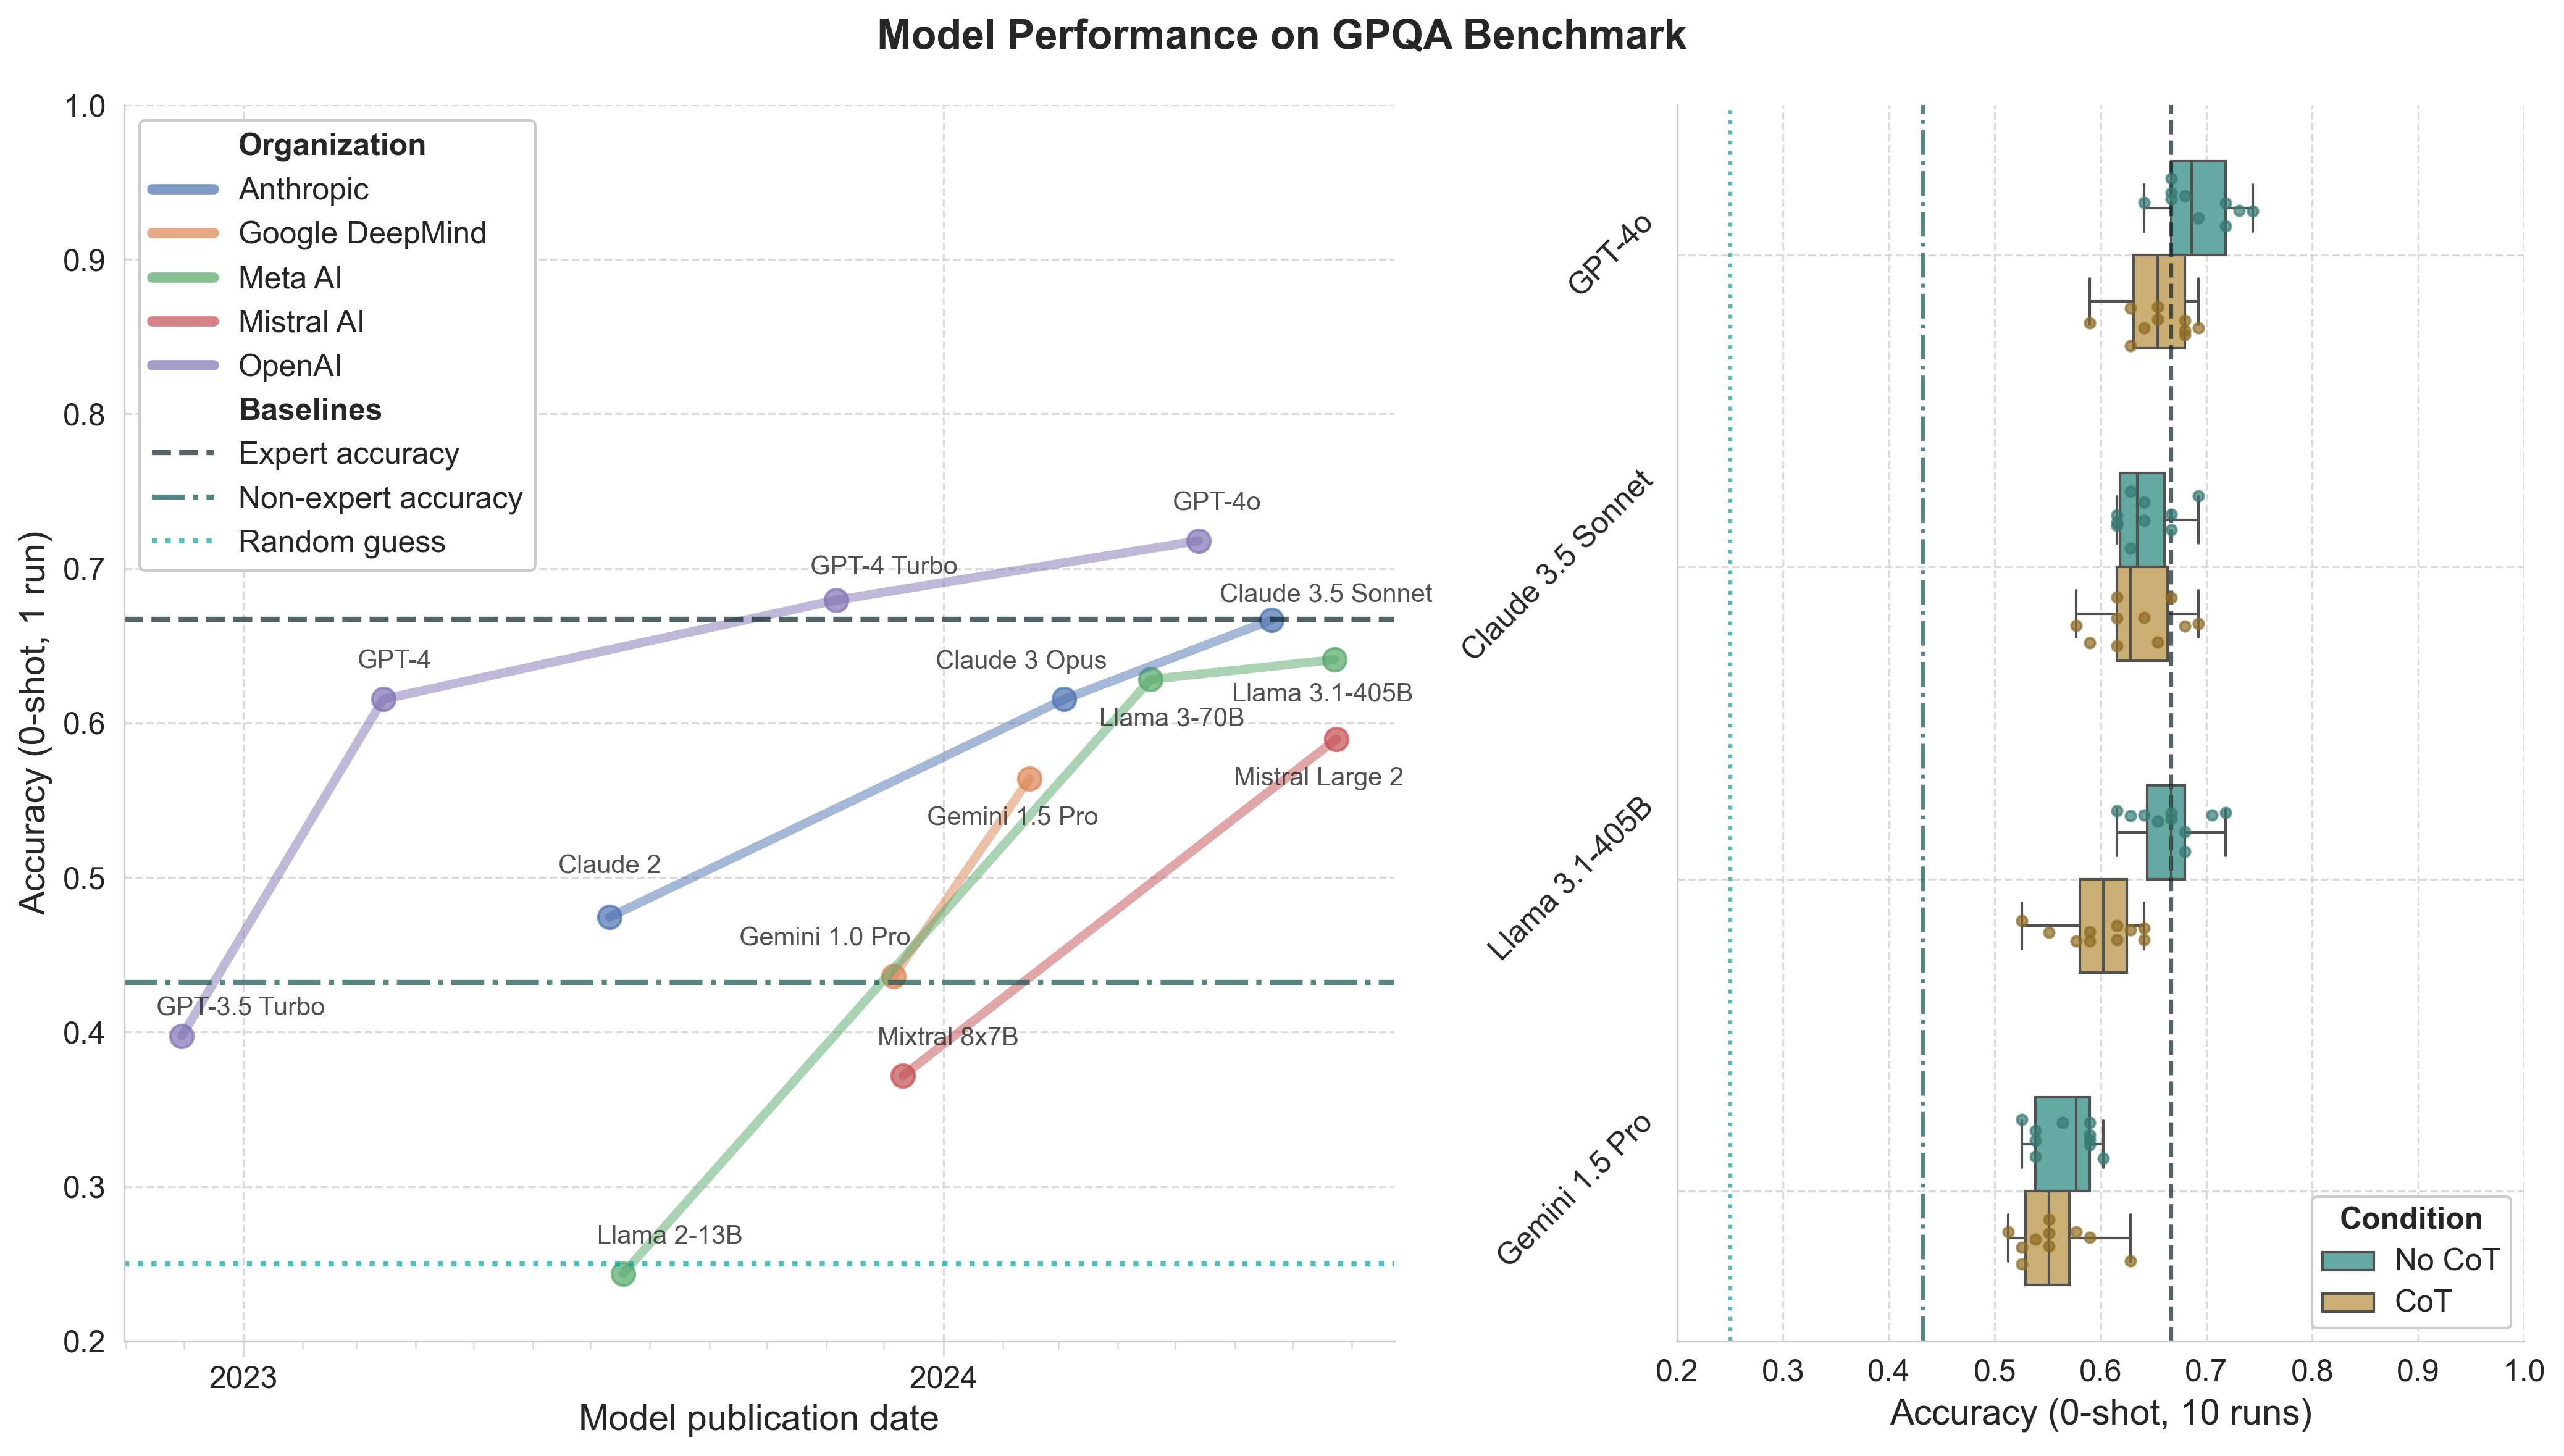

In [15]:
create_benchmark_figure(gpqa_zshot_1run_df, gpqa_zshot_10run_df, offsets, baselines, "GPQA", ylim, xlim, gpqa_zshot_cot_10run_df, legend_loc='upper left')

## Figure 3 - WMDP

In [16]:
wmdp_zshot_1run_results = process_log_file_dir(zshot_1run_path.format('wmdp'))
wmdp_zshot_1run_df = wmdp_zshot_1run_results.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

wmdp_zshot_10run_results = {}
for model in model_dir_names:
    wmdp_zshot_10run_results[model] = process_log_file_dir(zshot_10run_path.format('wmdp', model))
wmdp_zshot_10run_df = pd.concat(wmdp_zshot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

In [17]:
offsets = {
    "GPT-3.5 Turbo": (-10, 10),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-30, 8),
    "Claude 2": (-10, 10),
    "Claude 3 Opus": (-28, 5),
    "Claude 3.5 Sonnet": (-20, 8),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-15, -18),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-10, 10),
    "Gemini 1.5 Pro": (-40, -20),
    "Mixtral 8x7B": (-10, 10),
    "Mistral Large 2": (0, -20)
}

baselines = {
    "Random guess": {"value": 0.25, "color": '#00a9a5', "linestyle": ':', "label": 'Random guess'}
}

ylim = (0.2, 1.0)
xlim = (0.2, 1.0)

/var/folders/d_/hv1jrf512w51cf1t0s2w52v00000gn/T/ipykernel_45907/2621642398.py:92: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)


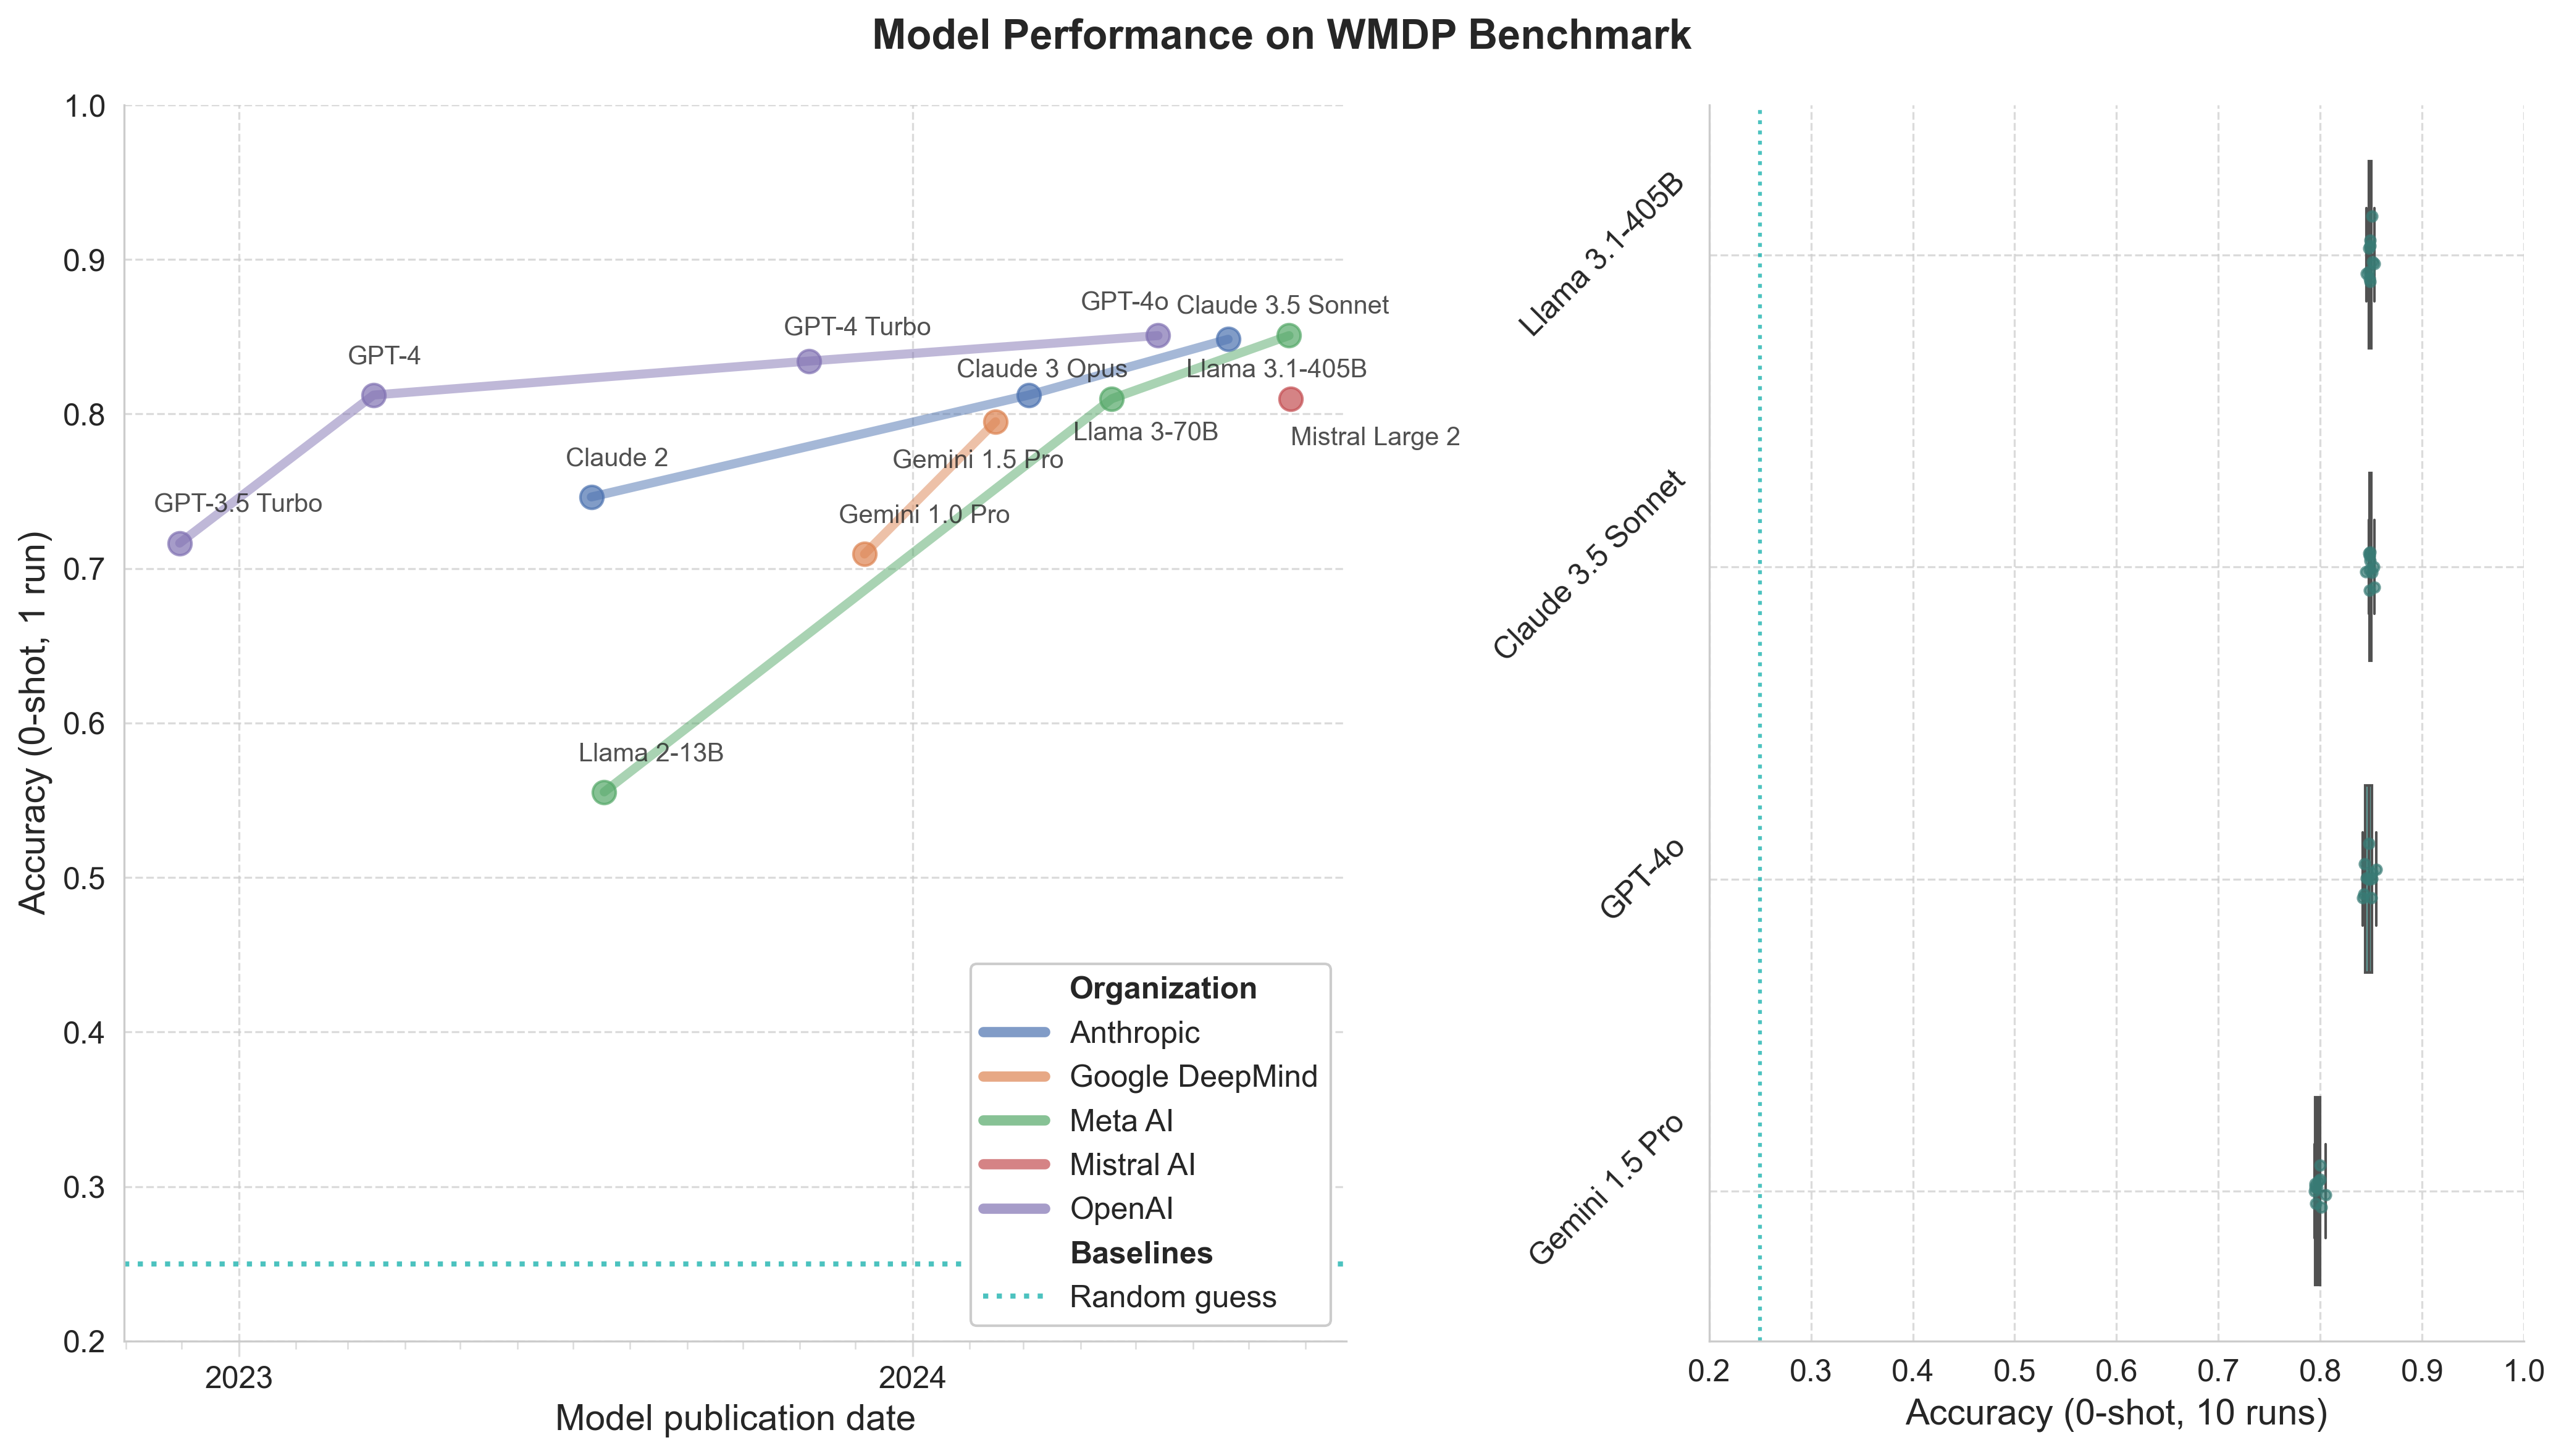

In [18]:
create_benchmark_figure(wmdp_zshot_1run_df, wmdp_zshot_10run_df, offsets, baselines, "WMDP", ylim, xlim, legend_loc='lower right')

## Figure 4 - LAB-Bench LitQA2

In [19]:
litqa2_zshot_1run_results = process_log_file_dir(zshot_1run_path.format('lab-bench-litqa2'))
litqa2_zshot_1run_df = litqa2_zshot_1run_results.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

litqa2_zshot_10run_results = {}
for model in model_dir_names:
    litqa2_zshot_10run_results[model] = process_log_file_dir(zshot_10run_path.format('lab-bench-litqa2', model))
litqa2_zshot_10run_df = pd.concat(litqa2_zshot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

In [20]:
offsets = {
    "GPT-3.5 Turbo": (-10, 6),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-30, 8),
    "Claude 2": (-20, 15),
    "Claude 3 Opus": (-50, -18),
    "Claude 3.5 Sonnet": (-20, 5),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-20, -20),
    "Llama 3.1-405B": (-30, -18),
    "Gemini 1.0 Pro": (-28, -18),
    "Gemini 1.5 Pro": (-40, -20),
    "Mixtral 8x7B": (-40, 8),
    "Mistral Large 2": (-10, 6)
}

random_guess = compute_random_baseline('futurehouse/lab-bench', 'LitQA2', 'train')
baselines = {
    "Expert accuracy": {"value": 0.70, "color": '#092327', "linestyle": '--', "label": 'Expert accuracy'},
    "Random guess": {"value": random_guess, "color": '#00a9a5', "linestyle": ':', "label": 'Random guess'}
}

ylim = (0.2, 1.0)
xlim = (0.2, 1.0)

/var/folders/d_/hv1jrf512w51cf1t0s2w52v00000gn/T/ipykernel_45907/2621642398.py:92: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)


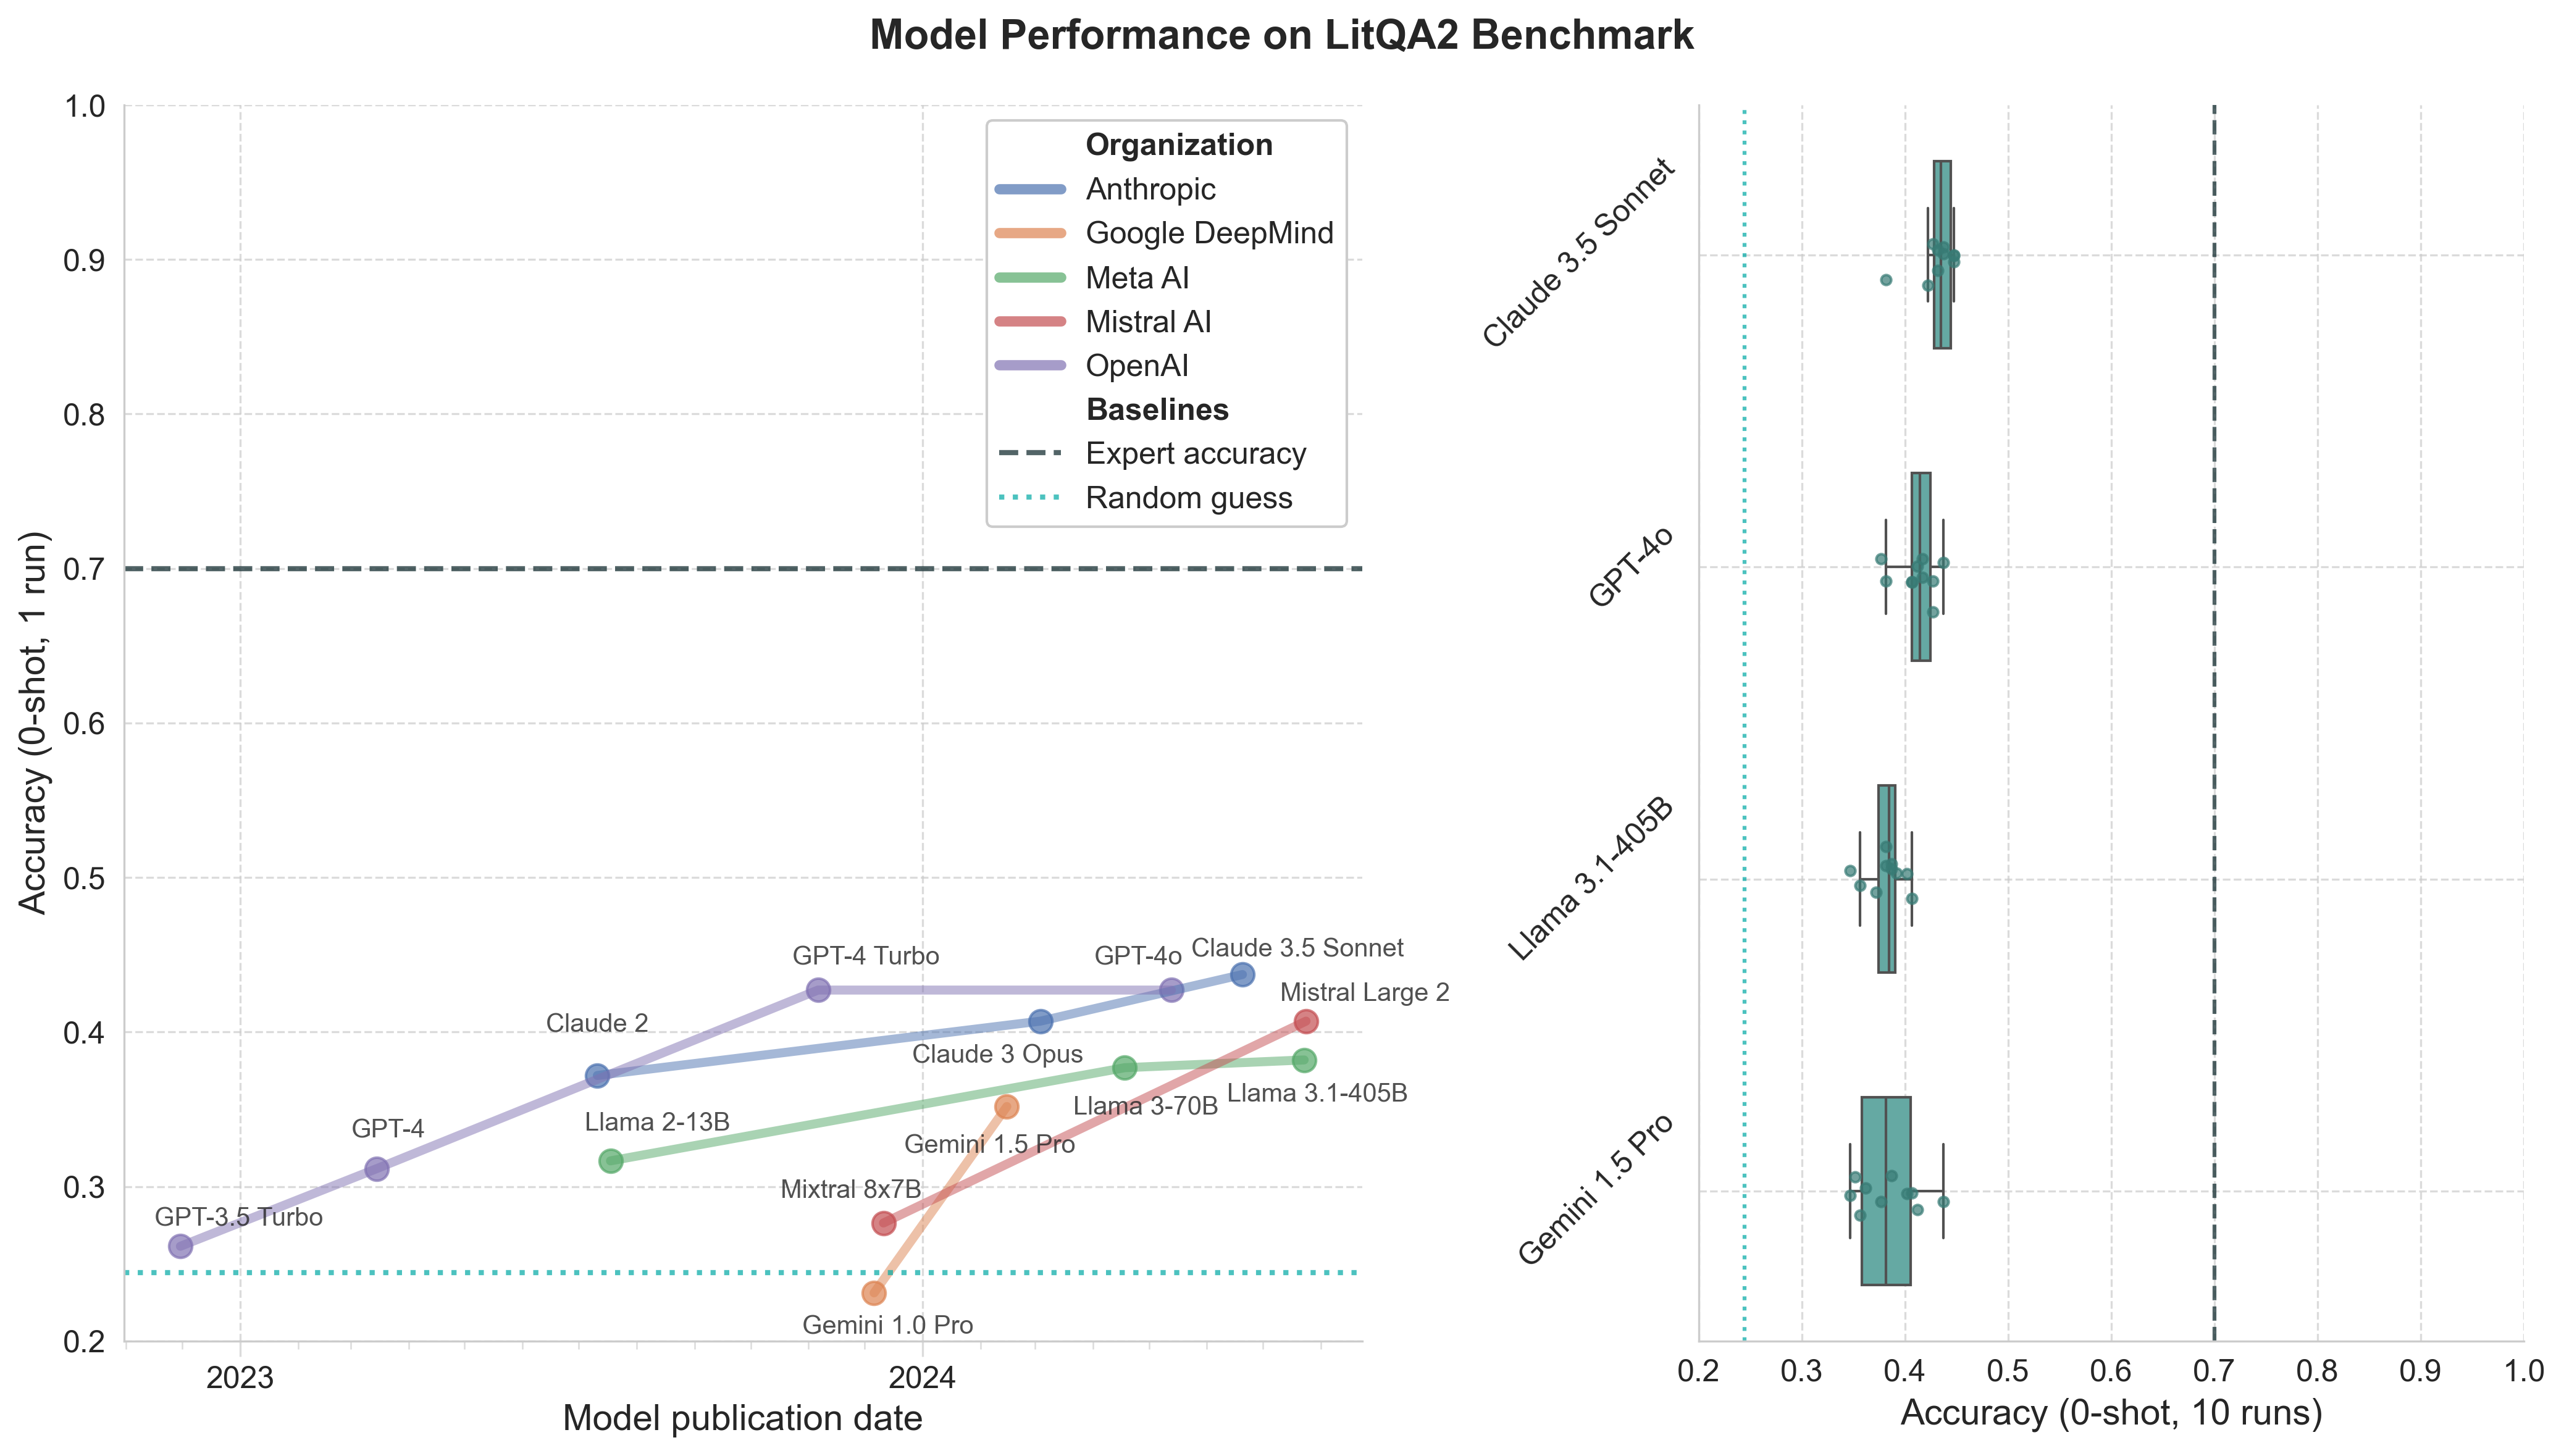

In [21]:
create_benchmark_figure(litqa2_zshot_1run_df, litqa2_zshot_10run_df, offsets, baselines, "LitQA2", ylim, xlim, legend_loc='upper right')

## Figure 5 - LAB-Bench CloningScenarios

In [22]:
cloningscenarios_zshot_1run_results = process_log_file_dir(zshot_1run_path.format('lab-bench-cloningscenarios'))
cloningscenarios_zshot_1run_df = cloningscenarios_zshot_1run_results.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

cloningscenarios_zshot_10run_results = {}
for model in model_dir_names:
    cloningscenarios_zshot_10run_results[model] = process_log_file_dir(zshot_10run_path.format('lab-bench-cloningscenarios', model))
cloningscenarios_zshot_10run_df = pd.concat(cloningscenarios_zshot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

In [23]:
offsets = {
    "GPT-3.5 Turbo": (-10, 6),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-10, 8),
    "GPT-4o": (-30, 8),
    "Claude 2": (-20, 10),
    "Claude 3 Opus": (-40, -18),
    "Claude 3.5 Sonnet": (-20, 8),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-20, -20),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-35, -22),
    "Gemini 1.5 Pro": (-40, 8),
    "Mixtral 8x7B": (-40, 8),
    "Mistral Large 2": (-15, -18)
}

random_guess = compute_random_baseline('futurehouse/lab-bench', 'CloningScenarios', 'train')
baselines = {
    "Expert accuracy": {"value": 0.60, "color": '#092327', "linestyle": '--', "label": 'Expert accuracy'},
    "Random guess": {"value": random_guess, "color": '#00a9a5', "linestyle": ':', "label": 'Random guess'}
}

ylim = (0.2, 1.0)
xlim = (0.2, 1.0)

/var/folders/d_/hv1jrf512w51cf1t0s2w52v00000gn/T/ipykernel_45907/2621642398.py:92: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)


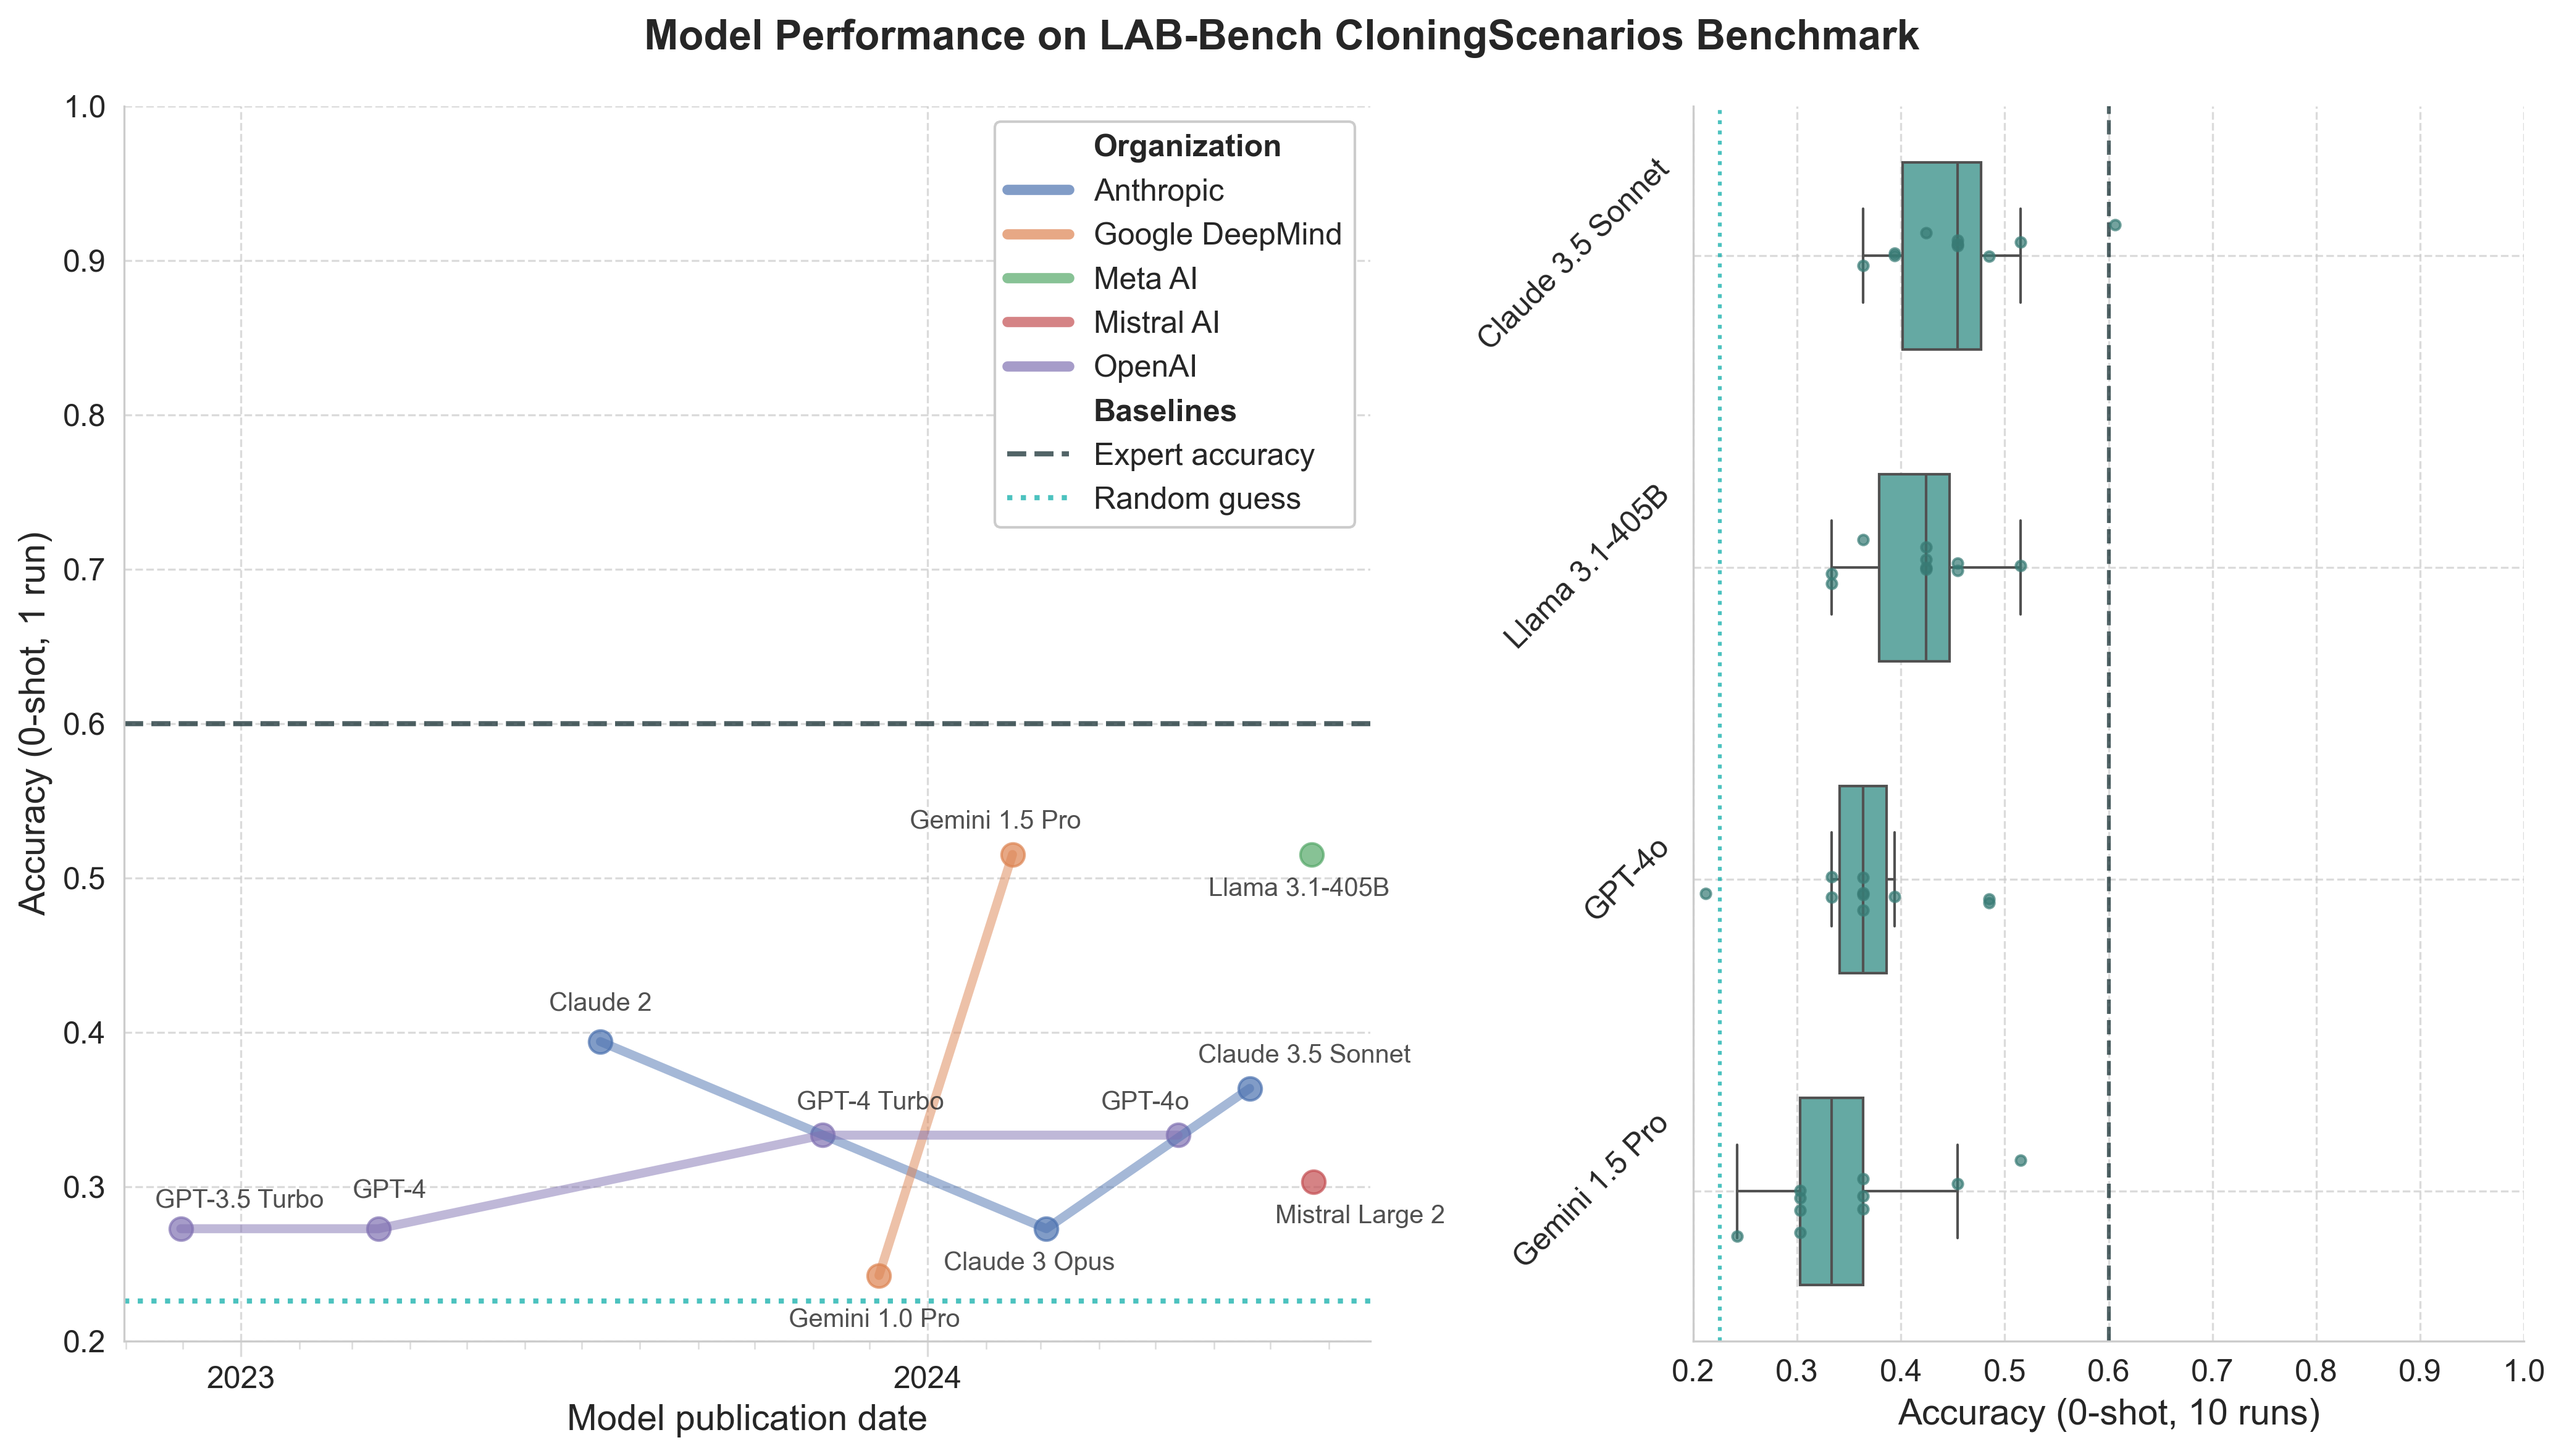

In [24]:
create_benchmark_figure(cloningscenarios_zshot_1run_df, cloningscenarios_zshot_10run_df, offsets, baselines, "LAB-Bench CloningScenarios", ylim, xlim, legend_loc='upper right')

## Figure 6 - LAB-Bench ProtocolQA

In [25]:
protocolqa_zshot_1run_results = process_log_file_dir(zshot_1run_path.format('lab-bench-protocolqa'))
protocolqa_zshot_1run_df = protocolqa_zshot_1run_results.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

protocolqa_zshot_10run_results = {}
protocolqa_zshot_cot_10run_results = {}
for model in model_dir_names:
    protocolqa_zshot_10run_results[model] = process_log_file_dir(zshot_10run_path.format('lab-bench-protocolqa', model))
    protocolqa_zshot_cot_10run_results[model] = process_log_file_dir(zshot_cot_10run_path.format('lab-bench-protocolqa', model))
protocolqa_zshot_10run_df = pd.concat(protocolqa_zshot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')
protocolqa_zshot_cot_10run_df = pd.concat(protocolqa_zshot_cot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

In [26]:
offsets = {
    "GPT-3.5 Turbo": (-10, 6),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-25, 8),
    "GPT-4o": (-25, 6),
    "Claude 2": (-20, 10),
    "Claude 3 Opus": (-40, 8),
    "Claude 3.5 Sonnet": (-20, 8),
    "Llama 2-13B": (-10, 10),
    "Llama 3-70B": (-20, -20),
    "Llama 3.1-405B": (-40, -18),
    "Gemini 1.0 Pro": (-35, -22),
    "Gemini 1.5 Pro": (-30, 7),
    "Mixtral 8x7B": (-40, 8),
    "Mistral Large 2": (0, 5)
}

random_guess = compute_random_baseline('futurehouse/lab-bench', 'ProtocolQA', 'train')
baselines = {
    "Expert accuracy": {"value": 0.79, "color": '#092327', "linestyle": '--', "label": 'Expert accuracy'},
    "Random guess": {"value": random_guess, "color": '#00a9a5', "linestyle": ':', "label": 'Random guess'}
}

ylim = (0.2, 1.0)
xlim = (0.2, 1.0)

/var/folders/d_/hv1jrf512w51cf1t0s2w52v00000gn/T/ipykernel_45907/2621642398.py:92: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)


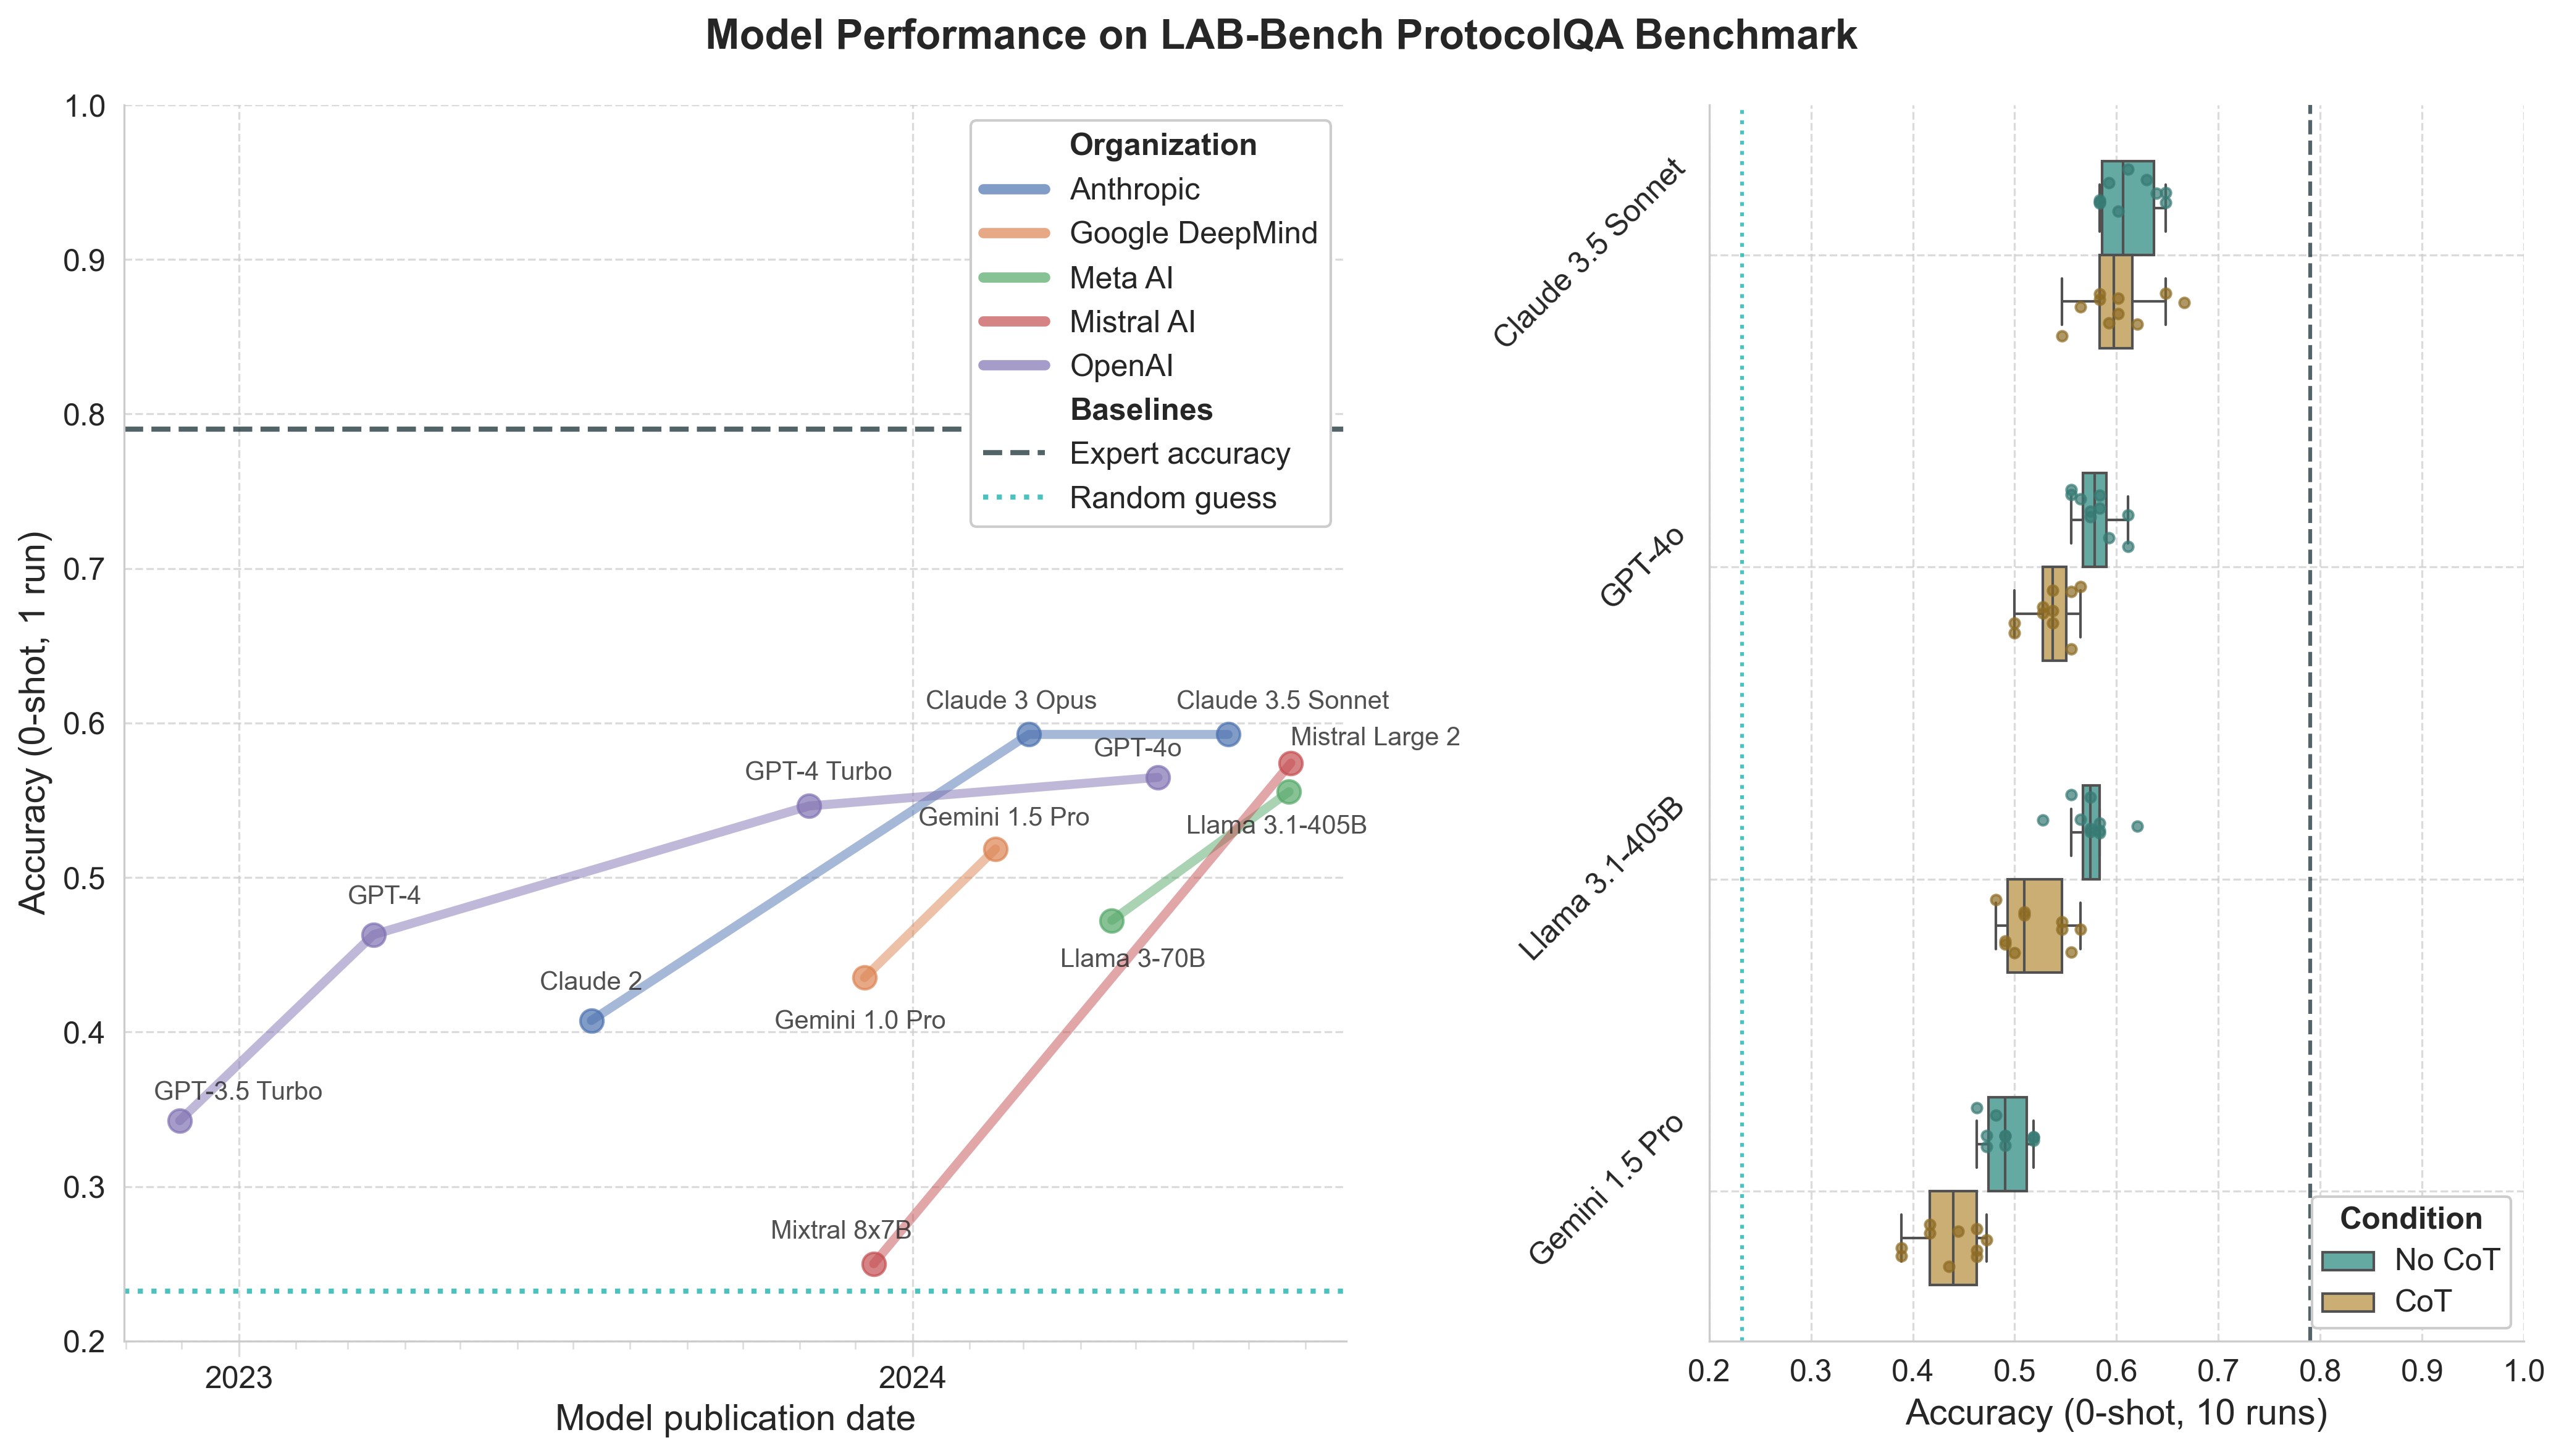

In [27]:
create_benchmark_figure(protocolqa_zshot_1run_df, protocolqa_zshot_10run_df, offsets, baselines, "LAB-Bench ProtocolQA", ylim, xlim, protocolqa_zshot_cot_10run_df, legend_loc='upper right')

## Figure 7 - PubMedQA

In [28]:
pubmedqa_zshot_1run_results = process_log_file_dir(zshot_1run_path.format('pubmedqa'))
pubmedqa_zshot_1run_df = pubmedqa_zshot_1run_results.merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

pubmedqa_zshot_10run_results = {}
pubmedqa_zshot_cot_10run_results = {}
for model in model_dir_names:
    pubmedqa_zshot_10run_results[model] = process_log_file_dir(zshot_10run_path.format('pubmedqa', model))
    pubmedqa_zshot_cot_10run_results[model] = process_log_file_dir(zshot_cot_10run_path.format('pubmedqa', model))
pubmedqa_zshot_10run_df = pd.concat(pubmedqa_zshot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')
pubmedqa_zshot_cot_10run_df = pd.concat(pubmedqa_zshot_cot_10run_results, axis=0).merge(models_metadata, left_on='inspect_model_name', right_on='inspect_model_name', how='left')

In [29]:
offsets = {
    "GPT-3.5 Turbo": (-10, 6),
    "GPT-4": (-10, 10),
    "GPT-4 Turbo": (-50, -18),
    "GPT-4o": (-8, 2),
    "Claude 2": (-20, -18),
    "Claude 3 Opus": (-40, -18),
    "Claude 3.5 Sonnet": (-30, -20),
    "Llama 2-13B": (-20, -18),
    "Llama 3-70B": (-20, 10),
    "Llama 3.1-405B": (-40, 8),
    "Gemini 1.0 Pro": (-50, -18),
    "Gemini 1.5 Pro": (-20, -20),
    "Mixtral 8x7B": (-30, -18),
    "Mistral Large 2": (-40, -18)
}

baselines = {
    "Expert accuracy": {"value": 0.78, "color": '#092327', "linestyle": '--', "label": 'Expert accuracy'},
    "Random guess": {"value": 0.333, "color": '#00a9a5', "linestyle": ':', "label": 'Random guess'}
}

ylim = (0.2, 1.0)
xlim = (0.2, 1.0)

/var/folders/d_/hv1jrf512w51cf1t0s2w52v00000gn/T/ipykernel_45907/2621642398.py:92: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  legend = ax.legend(handles=legend_elements, loc=legend_loc, fontsize=12)


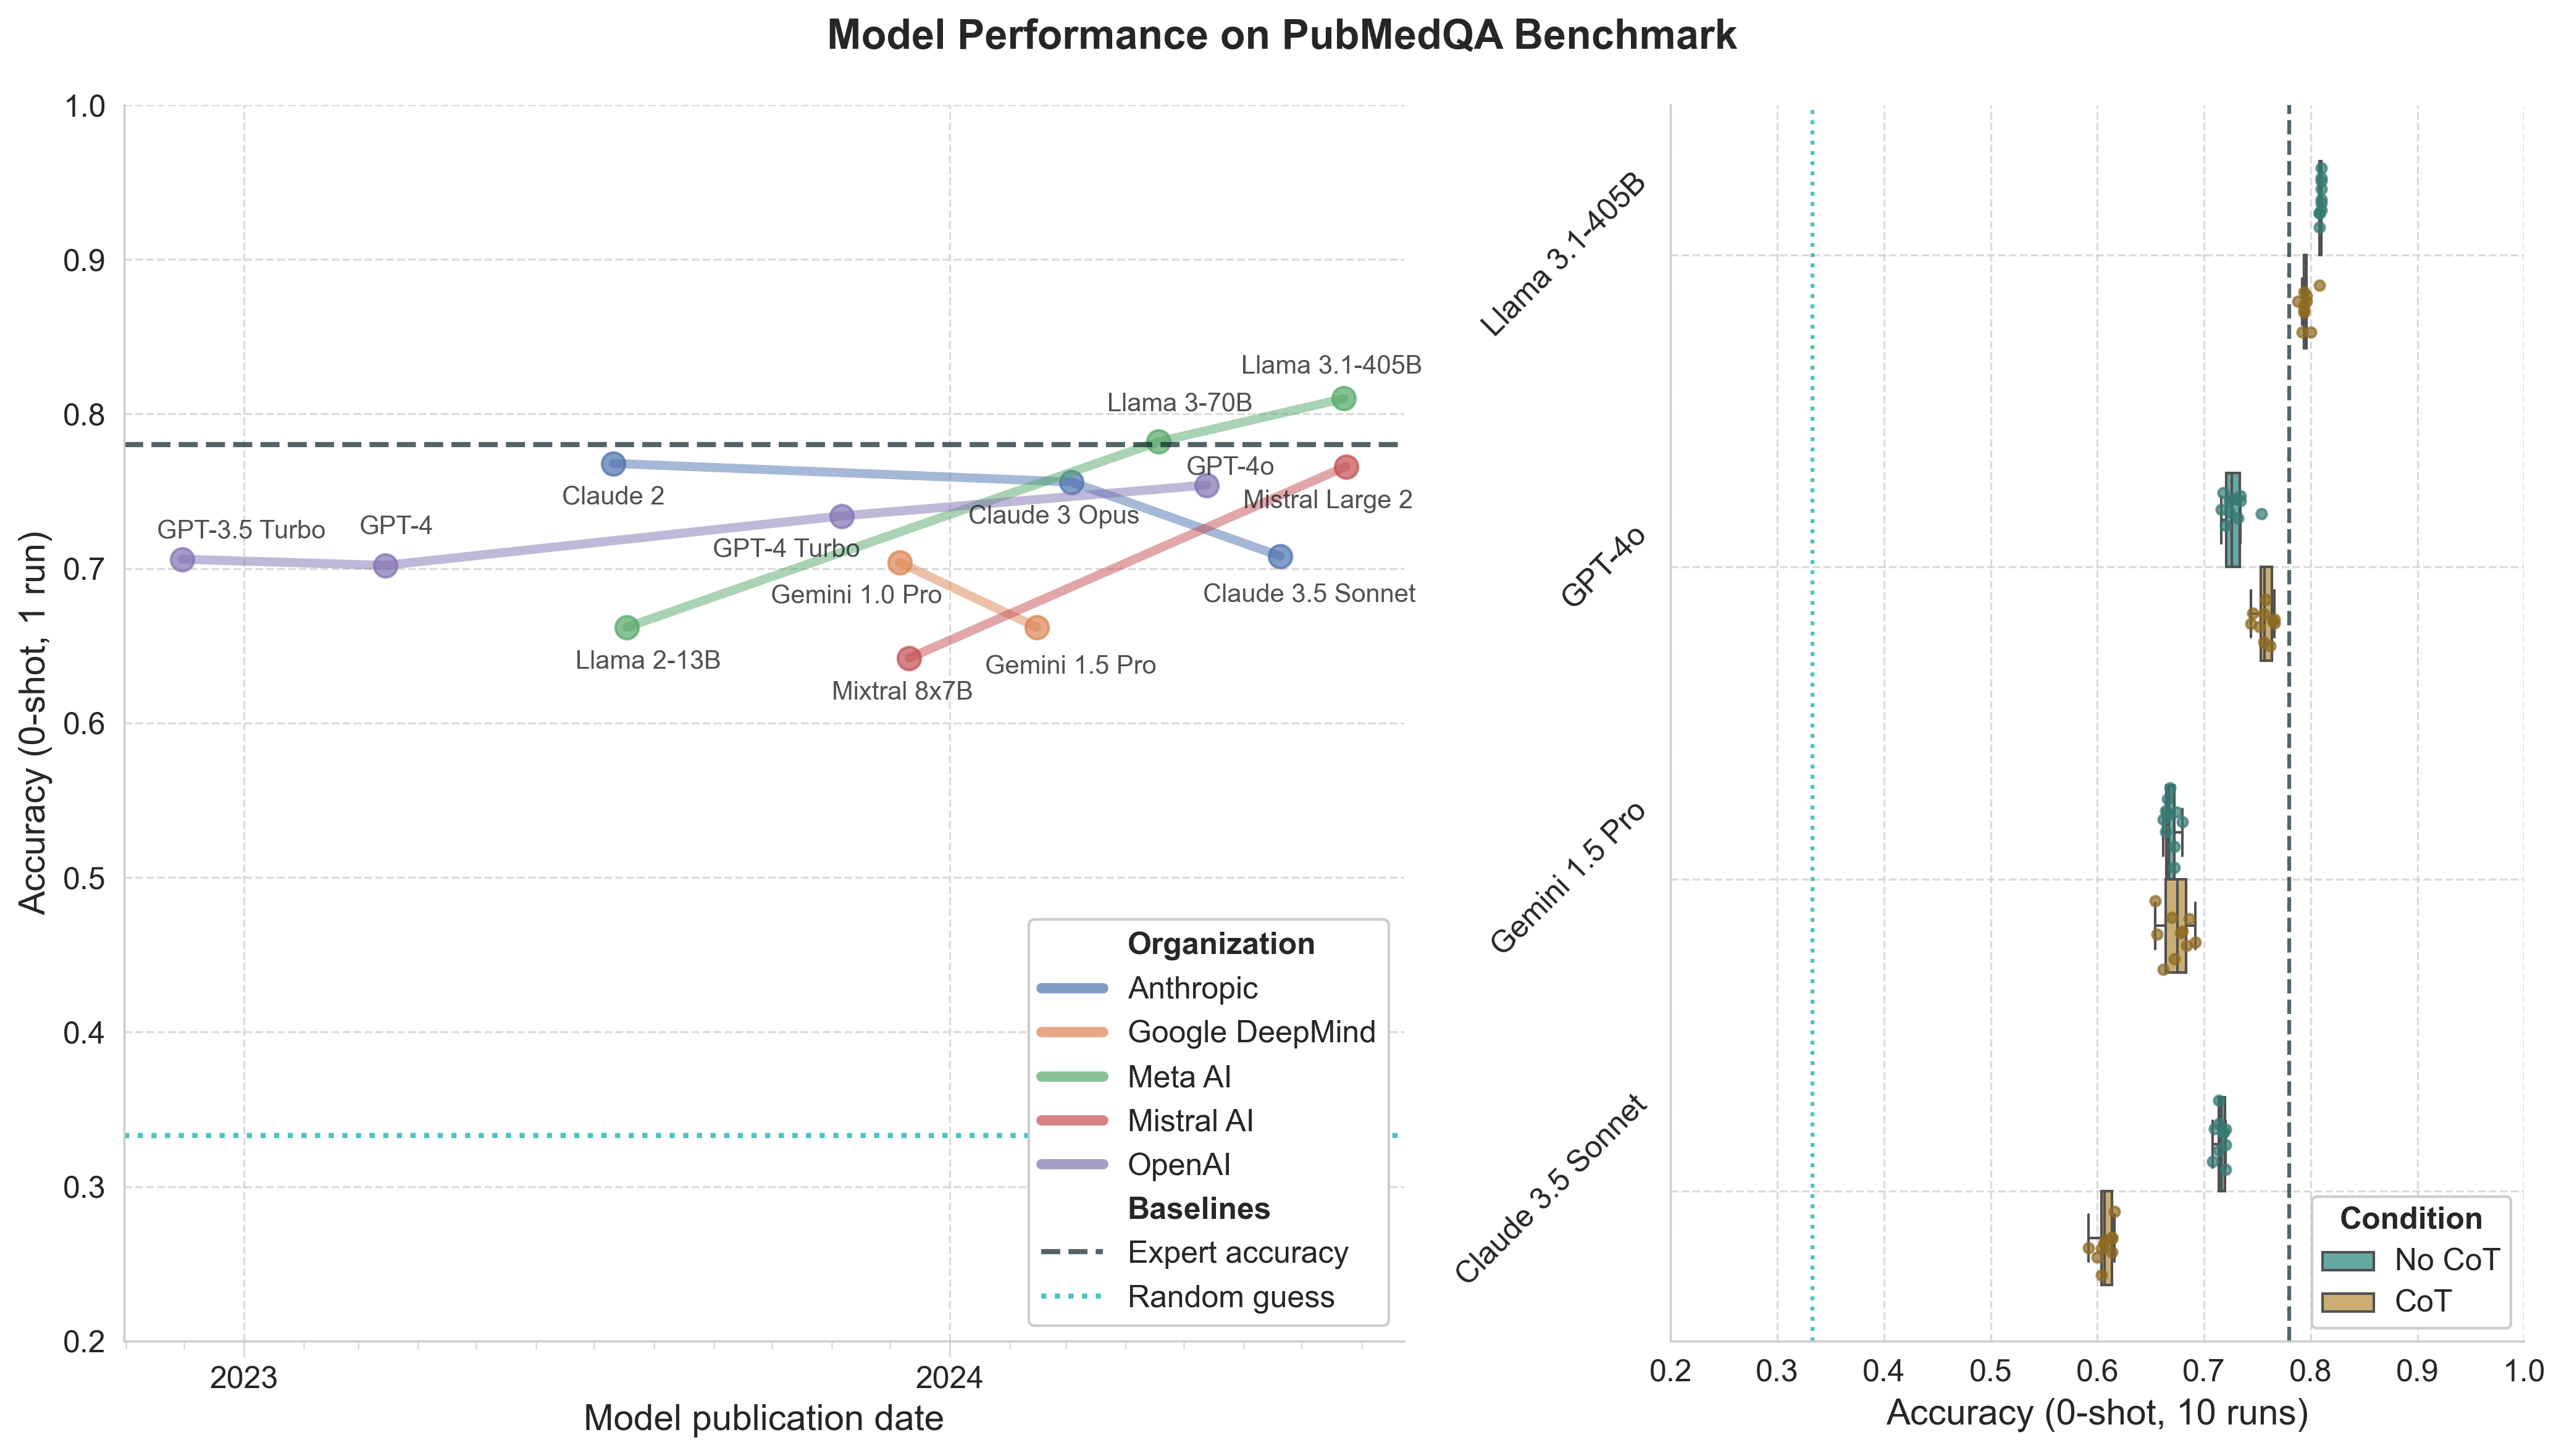

In [30]:
create_benchmark_figure(pubmedqa_zshot_1run_df, pubmedqa_zshot_10run_df, offsets, baselines, "PubMedQA", ylim, xlim, pubmedqa_zshot_cot_10run_df, legend_loc='lower right')